In [84]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data (as before)
n_cells = 100
n_genes = 1000
n_peaks = 5000
n_features = 500

scrnaseq_data = np.random.negative_binomial(n=5, p=0.3, size=(n_cells, n_genes))
scatacseq_data = np.random.binomial(n=1, p=0.1, size=(n_cells, n_peaks))
cell_painting_data = np.random.normal(loc=0, scale=1, size=(n_cells, n_features))

# Combine all datasets
combined_data = np.concatenate([scrnaseq_data, scatacseq_data, cell_painting_data], axis=1)

# Normalize the data
combined_data = (combined_data - np.mean(combined_data, axis=0)) / np.std(combined_data, axis=0)

# Define VAE architecture
latent_dim = 32
input_dim = combined_data.shape[1]

class VAE(keras.Model):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()

    def build_encoder(self):
        inputs = keras.Input(shape=(self.input_dim,))
        x = keras.layers.Dense(256, activation="relu")(inputs)
        x = keras.layers.Dense(128, activation="relu")(x)
        z_mean = keras.layers.Dense(self.latent_dim)(x)
        z_log_var = keras.layers.Dense(self.latent_dim)(x)
        return keras.Model(inputs, [z_mean, z_log_var], name="encoder")

    def build_decoder(self):
        inputs = keras.Input(shape=(self.latent_dim,))
        x = keras.layers.Dense(128, activation="relu")(inputs)
        x = keras.layers.Dense(256, activation="relu")(x)
        outputs = keras.layers.Dense(self.input_dim)(x)
        return keras.Model(inputs, outputs, name="decoder")

    def reparameterize(self, z_mean, z_log_var):
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        return reconstructed, z_mean, z_log_var

# Create VAE model
vae = VAE(input_dim, latent_dim)

# Define loss function
def vae_loss(model, x):
    x_reconstructed, z_mean, z_log_var = model(x)
    reconstruction_loss = tf.reduce_mean(keras.losses.mse(x, x_reconstructed))
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    return reconstruction_loss + kl_loss

# Compile the model
vae.compile(optimizer=keras.optimizers.Adam())

# Custom training loop
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = vae_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Training loop
epochs = 50
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices(combined_data).shuffle(1000).batch(batch_size)

for epoch in range(epochs):
    total_loss = 0
    num_batches = 0
    for batch in train_dataset:
        loss = train_step(vae, batch, vae.optimizer)
        total_loss += loss
        num_batches += 1
    
    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{epochs}, Loss: {average_loss:.4f}")

# Get latent representations
latent_representations = vae.encoder.predict(combined_data)[0]

2024-08-06 19:23:22.532900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:22.640758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:22.728915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/50, Loss: 1.6041
Epoch 2/50, Loss: 1.8640
Epoch 3/50, Loss: 1.3558


2024-08-06 19:23:22.824311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:22.922267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:23.004224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4/50, Loss: 1.2380
Epoch 5/50, Loss: 1.1267
Epoch 6/50, Loss: 1.0972


2024-08-06 19:23:23.088732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:23.183830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:23.278946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7/50, Loss: 1.0569
Epoch 8/50, Loss: 1.0250
Epoch 9/50, Loss: 1.0151


2024-08-06 19:23:23.360456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:23.457999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:23.543585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 10/50, Loss: 1.0084
Epoch 11/50, Loss: 0.9981
Epoch 12/50, Loss: 0.9987


2024-08-06 19:23:23.621520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:23.707939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:23.790481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 13/50, Loss: 0.9929
Epoch 14/50, Loss: 0.9994
Epoch 15/50, Loss: 0.9950


2024-08-06 19:23:23.884132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:23.962634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:24.055212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16/50, Loss: 1.0098
Epoch 17/50, Loss: 1.0024
Epoch 18/50, Loss: 0.9994


2024-08-06 19:23:24.139251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:24.232863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:24.314806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 19/50, Loss: 1.0008
Epoch 20/50, Loss: 0.9974
Epoch 21/50, Loss: 0.9993


2024-08-06 19:23:24.403896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:24.489379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:24.583015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 22/50, Loss: 0.9946
Epoch 23/50, Loss: 1.0021
Epoch 24/50, Loss: 0.9992


2024-08-06 19:23:24.676080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:24.769331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:24.854022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 25/50, Loss: 0.9999
Epoch 26/50, Loss: 0.9948
Epoch 27/50, Loss: 1.0075


2024-08-06 19:23:24.935119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:25.016399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:25.099951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 28/50, Loss: 1.0043
Epoch 29/50, Loss: 0.9959
Epoch 30/50, Loss: 0.9985


2024-08-06 19:23:25.172434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:25.252362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:25.357507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 31/50, Loss: 1.0022
Epoch 32/50, Loss: 1.0032
Epoch 33/50, Loss: 0.9988


2024-08-06 19:23:25.460656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:25.539697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:25.627534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 34/50, Loss: 1.0052
Epoch 35/50, Loss: 0.9984
Epoch 36/50, Loss: 0.9949


2024-08-06 19:23:25.711731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:25.789232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:25.872319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 37/50, Loss: 0.9972
Epoch 38/50, Loss: 0.9949
Epoch 39/50, Loss: 1.0018


2024-08-06 19:23:25.953614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:26.034231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:26.112377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 40/50, Loss: 1.0002
Epoch 41/50, Loss: 0.9989
Epoch 42/50, Loss: 0.9968


2024-08-06 19:23:26.187915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:26.278685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:26.361118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 43/50, Loss: 1.0015
Epoch 44/50, Loss: 0.9963
Epoch 45/50, Loss: 1.0003


2024-08-06 19:23:26.437611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:26.529395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:26.607051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 46/50, Loss: 0.9985
Epoch 47/50, Loss: 1.0010
Epoch 48/50, Loss: 0.9962
Epoch 49/50, Loss: 0.9958
Epoch 50/50, Loss: 1.0061
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

2024-08-06 19:23:26.703555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 19:23:26.781641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


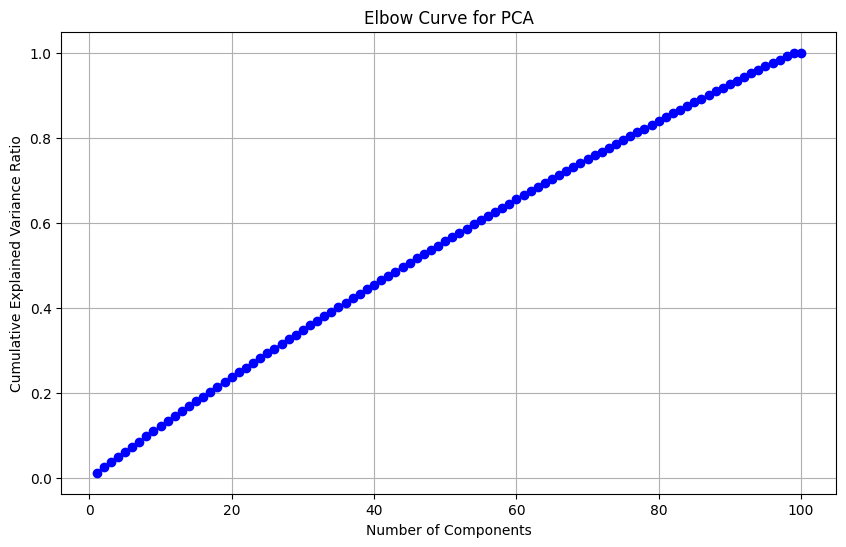

Elbow point (90% explained variance): 87


100%|██████████| 100/100 [00:27<00:00,  3.62it/s]


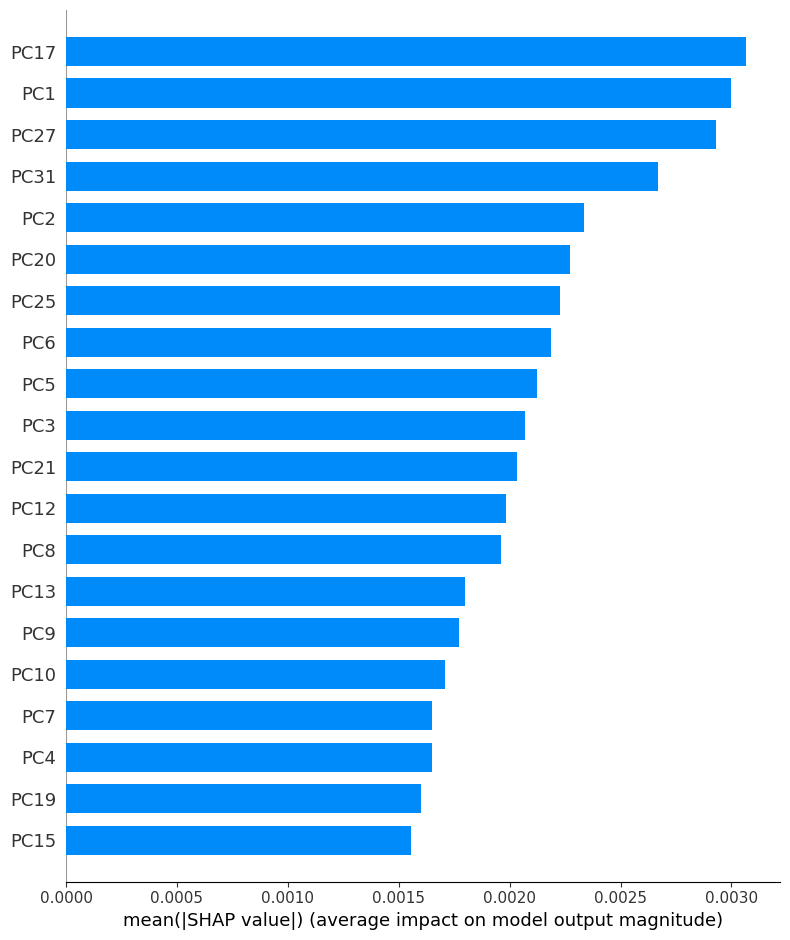

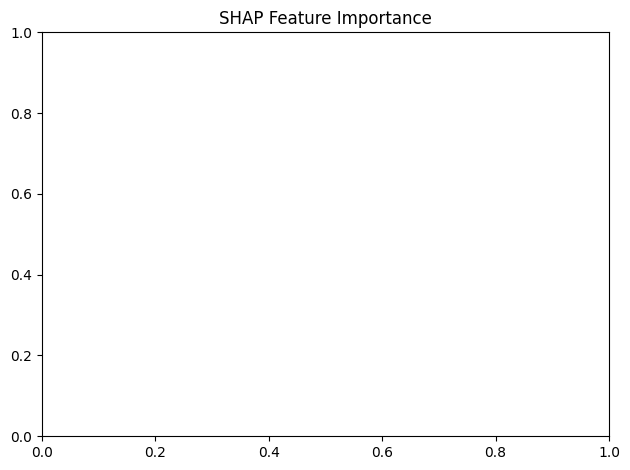

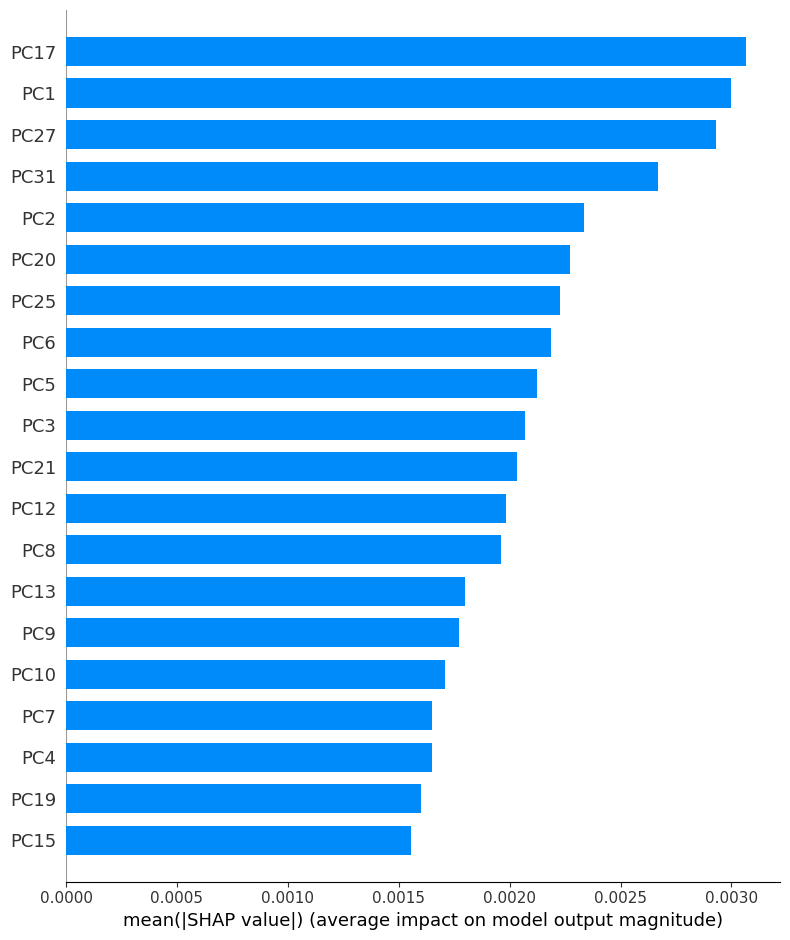

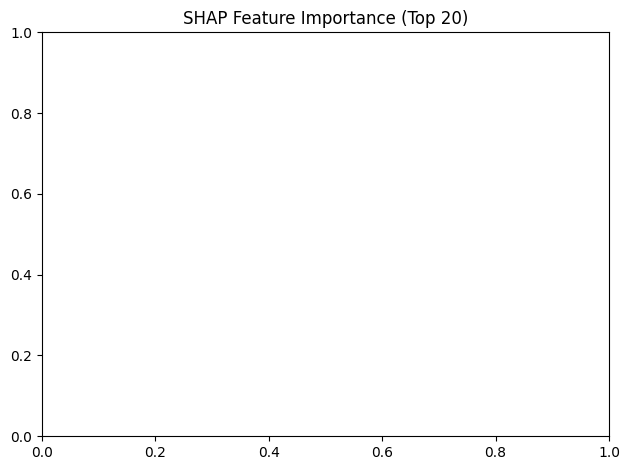

<Figure size 1000x600 with 0 Axes>

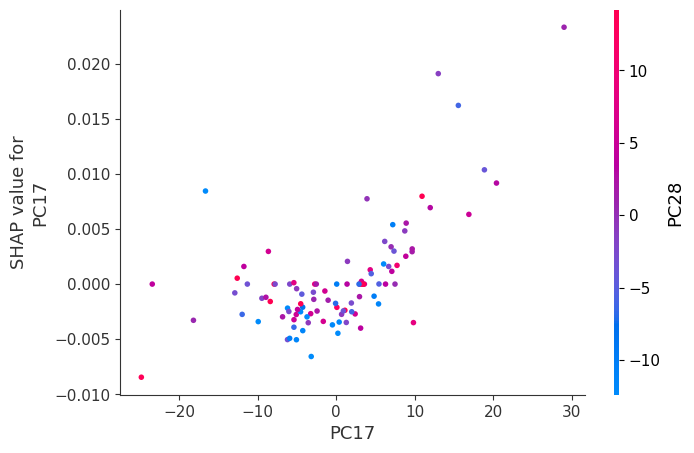

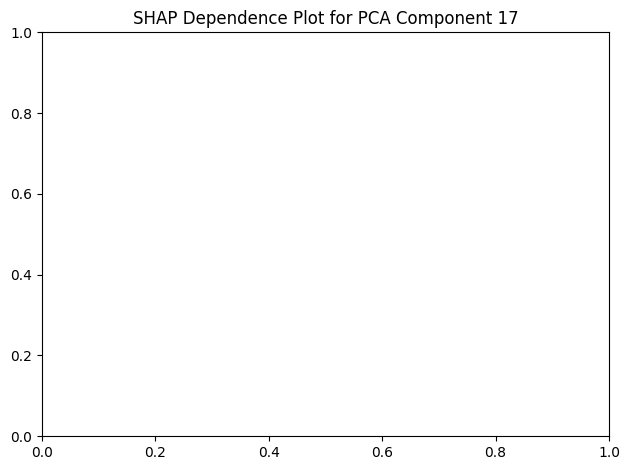

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import shap
from sklearn.ensemble import RandomForestRegressor

# Assuming we have our combined_data

# 1. Perform PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(combined_data)

pca = PCA()
pca_results = pca.fit_transform(scaled_data)

# 2. Implement the elbow method for PCA
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Elbow Curve for PCA')
plt.grid(True)
plt.show()

# Find the elbow point (you may need to adjust this based on the plot)
elbow_point = np.argmax(cumulative_variance_ratio > 0.9) + 1
print(f"Elbow point (90% explained variance): {elbow_point}")

# 3. Calculate and visualize SHAP features
# We'll use the top PCA components to predict a subset of the original features

n_components = min(32, elbow_point)  # Use either 32 or the elbow point, whichever is smaller
top_pca_components = pca_results[:, :n_components]

# Select a subset of original features (e.g., first 100) for SHAP analysis
n_features_for_shap = 100
subset_features = combined_data[:, :n_features_for_shap]

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(top_pca_components, subset_features)

# Define a function to predict the mean output across all features
def f(X):
    return rf_model.predict(X).mean(axis=1)

# Use KernelExplainer
explainer = shap.KernelExplainer(f, top_pca_components)
shap_values = explainer.shap_values(top_pca_components, nsamples=100)  # Adjust nsamples as needed

# Plot SHAP summary
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, top_pca_components, plot_type="bar", feature_names=[f"PC{i+1}" for i in range(n_components)])
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

# Plot SHAP summary for the top 20 features
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, top_pca_components, plot_type="bar", feature_names=[f"PC{i+1}" for i in range(n_components)], max_display=20)
plt.title("SHAP Feature Importance (Top 20)")
plt.tight_layout()
plt.show()

# SHAP dependence plot for the most important feature
feature_importance = np.abs(shap_values).mean(axis=0)
most_important_feature = feature_importance.argmax()
plt.figure(figsize=(10, 6))
shap.dependence_plot(most_important_feature, shap_values, top_pca_components, feature_names=[f"PC{i+1}" for i in range(n_components)])
plt.title(f"SHAP Dependence Plot for PCA Component {most_important_feature+1}")
plt.tight_layout()
plt.show()